## ENVM1400 - I & A - Volta group - DGRE
made by: David Haasnoot

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# plotting/mapmaknig
import geopandas as gpd
import folium
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

In [2]:
path = os.getcwd()
home_path = os.path.dirname(os.path.dirname(path))

gis_folder = f'{home_path}\\QGIS project'

In [3]:
# load in all the text files, saves typing :)
glob.glob("*.txt")

['BLACK VOLTA, VONKORO.txt',
 'BOUGOURIBA, DAN.txt',
 'dayfile.txt',
 'discharge_combined_adjusted.txt',
 'MOU HOUN, BLACK VOLTA, SAMANDENI.txt',
 'MOU HOUN, BLACK VOLTA,DAPOLA.txt',
 'NAKANBE, WHITE VOLTA, YAKALA.txt',
 'NAKANBE, WHITE VOLTA, YILOU.txt',
 'NAZINON, RED VOLTA, DAKAYE.txt',
 'PENDJARI, PORGA.txt',
 'SINGOU, SAMBOALI.txt',
 'volt_day.txt']

In [4]:
# google maps locations
links = ["https://goo.gl/maps/B6rpdv8nrVrWcMGY9",
         "https://goo.gl/maps/k2Hn8jJ3aM2FLVfMA",
         'https://goo.gl/maps/GqkaLwHdsxNS8VQr7',
         "https://goo.gl/maps/bnRr46YB6gbaX7VV9",
         "https://goo.gl/maps/ymWchRtzaiqa3oqBA",
         "https://goo.gl/maps/cCHzihPvBMnuwokY8",
         "https://goo.gl/maps/9HoAGcJncrnZwyXs5",
         "https://goo.gl/maps/G1ZCWiA575tm8qUP8",
         "https://goo.gl/maps/NRH7s4NNWT2E3uvS6"
        ]

# corresponding lat/long locations
lat_lon = [[9.171205333996518, -2.7448412667392383],
           [10.867875919446051, -3.722479273356632],
           [11.458715461275865, -4.469476596583681],
           [10.572861584223373, -2.914134892035999],
           [11.344607777805557, -0.5289654226974667],
           [12.99971043752888, -1.570603458131631],
           [11.777456003610485, -1.6001563849044829],
           [11.045433053420533, 0.959913528639681],
           [11.279536764583742, 1.0158889285854777]        
         ]

In [5]:
# names of wanted stations
locations = ['BLACK VOLTA, VONKORO.txt',
             'BOUGOURIBA, DAN.txt',
             'MOU HOUN, BLACK VOLTA, SAMANDENI.txt',
             'MOU HOUN, BLACK VOLTA,DAPOLA.txt',
             'NAKANBE, WHITE VOLTA, YAKALA.txt',
             'NAKANBE, WHITE VOLTA, YILOU.txt',
             'NAZINON, RED VOLTA, DAKAYE.txt',
             'PENDJARI, PORGA.txt',
             'SINGOU, SAMBOALI.txt']

In [6]:
# laod in the data
df_per_location_lst = []
for i in range(len(locations)):
    df = pd.read_csv(locations[i], delimiter=",")
    # do prosessing of the date columns
    df['n_month_row'] = df.apply(lambda x: str(x.date).strip()[0],axis=1)
    df['year'] = df.apply(lambda x: str(x.date).strip()[1:].strip()[-4:],axis=1)
    df['month'] = df.apply(lambda x: str(x.date).strip()[1:].strip()[:-4],axis=1)
    # rename the index to the station name
    df.index.name = locations[i][:-4]
    # remove the original date column
    df = df.drop(columns="date")

    df_lst = []
    # make a list of dfs per month including
    for month_index in np.arange(0, len(df),3):
        # one month is 3 rows of data
        month = df[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']].iloc[month_index:month_index+3]\
                                                                         .astype(float).to_numpy()
        # palce these 30 days in one numpy array, remove any data unwanted (9999)
        new_month_data = month.flatten()[~np.in1d(month.flatten(), np.array(9999))] 
        dates = []
        # create an index column using pandas Timestamp (could be more efficient)
        for day in range(1,len(new_month_data)+1):
            date_string = f'{df.iloc[month_index].year}-{df.iloc[month_index].month}-{day}'
            dates.append(pd.Timestamp(date_string))
        # create a df for a month with the data
        new_month = pd.DataFrame(index=dates, data=new_month_data, columns=[f'{str(locations[i][:-4]).lower()}'])
        # add each month to a list 
        df_lst.append(new_month)
    # combine all these months 
    df_per_location_lst.append(pd.concat(df_lst))

# remove unrealisticly high data
df_per_location_lst[-2] = df_per_location_lst[-2][df_per_location_lst[-2] < 1e6]

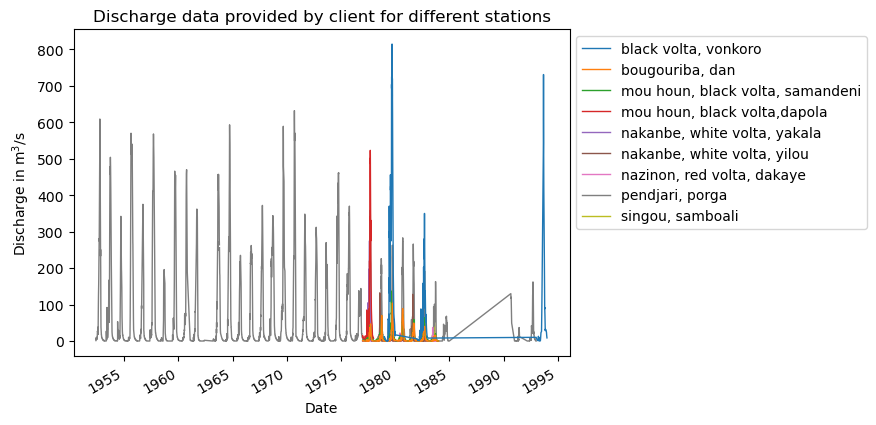

In [14]:
# plot the data above 
fig, ax = plt.subplots(1)
for i in range(len(locations)):
    df_per_location_lst[i].plot(lw=1,color=f"C{i}",ax=ax,zorder=10-i)
ax.legend(bbox_to_anchor=(1,1))
ax.get_xticks()
# ax.set_xlim(2557,5112)

ax.set_ylabel("Discharge in m$^3$/s")
ax.set_xlabel("Date")
ax.set_title("Discharge data provided by client for different stations");

fig.savefig("Discharge_data_client.png")

In [8]:
df = pd.DataFrame(columns= ["name","lat", "lon"], data=list(zip(locations,np.array(lat_lon)[:,0],np.array(lat_lon)[:,1])))

In [9]:
df

,name,lat,lon
0,"BLACK VOLTA, VONKORO.txt",9.171205,-2.744841
1,"BOUGOURIBA, DAN.txt",10.867876,-3.722479
2,"MOU HOUN, BLACK VOLTA, SAMANDENI.txt",11.458715,-4.469477
3,"MOU HOUN, BLACK VOLTA,DAPOLA.txt",10.572862,-2.914135
4,"NAKANBE, WHITE VOLTA, YAKALA.txt",11.344608,-0.528965
5,"NAKANBE, WHITE VOLTA, YILOU.txt",12.999710,-1.570603
6,"NAZINON, RED VOLTA, DAKAYE.txt",11.777456,-1.600156
7,"PENDJARI, PORGA.txt",11.045433,0.959914
8,"SINGOU, SAMBOALI.txt",11.279537,1.015889


In [10]:
# outline = gpd.read_file("region_boundary_burkina_faso.geojson")
geometry = gpd.points_from_xy(df.lon, df.lat, crs="EPSG:4326")
gdf_stations = gpd.GeoDataFrame(data=df, geometry=geometry)

In [17]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))

In [18]:
geometry = gpd.points_from_xy(df.lon, df.lat, crs="EPSG:4326")
gdf_stations = gpd.GeoDataFrame(data=df, geometry=geometry)

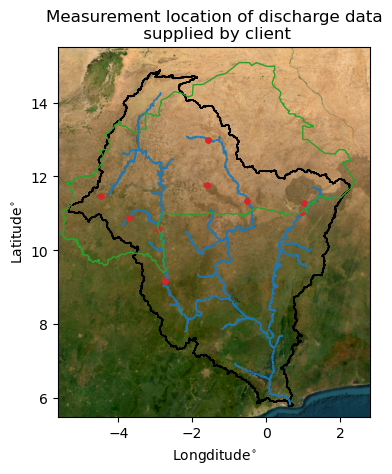

In [20]:
# quick way to get the bounds 
fig, ax = plt.subplots()

#adding features
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
main_rivers.plot(ax=ax, color="C0",zorder=1)
country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)

# get the bounds to add background
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

# add stations
gdf_stations.plot(ax=ax,color="C3",markersize=15,zorder=5)
with rasterio.open(get_background_map("stations", bounds_stations)) as r:
    rioshow(r, ax=ax)


ax.set_ylim((5.5,15.5))
ax.set_title("Measurement location of discharge data\n supplied by client")
ax.set_xlabel("Longditude$^{\circ}$");
ax.set_ylabel("Latitude$^{\circ}$");

In [24]:
output = False
if output:
    gdf_stations.to_file(f"{home_path}\\data\\Combining data\\discharge_data_client.geojson")